**This is an RFM-analysis of an online-store based on the distribution of values for recency, frequency, and monetary value. I also analysed this dataset using K-Means Clustering.You can find it in My Projects --> RFM K-Means Clustering.**<br/>
<br/>
The dataset was downloaded from kaggle.com --> <a href="https://www.kaggle.com/carrie1/ecommerce-data">E-Commerce Data.</a>  Below is its description:<br/>
"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

# STAGE 1. DATA PREPROCESSING

In [1]:
import numpy as np 
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('C:/Users/Yoga/Examples/data.csv',encoding='cp1252')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

How many missing values?

In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Let's drop the rows with missing CustomerIDs and replace missing Descriptions with 'unknown'

In [6]:
df.dropna(subset=['CustomerID'], inplace=True)

In [7]:
df=df.fillna('unknown')

Let's check what's left

In [8]:
df.shape

(406829, 8)

In [9]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
#Let's change the type of CustomerID
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [11]:
df['CustomerID']=df['CustomerID'].astype(int)

Let's see the list of countries in our dataset:

In [12]:
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [13]:
df.groupby('Country').agg({'InvoiceNo':'count'})\
.sort_values(by='InvoiceNo',ascending=False)\
.rename(columns={'InvoiceNo':'invoices_count'}).head(10)

,invoices_count
Country,
United Kingdom,361878
Germany,9495
France,8491
EIRE,7485
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,1877
Portugal,1480


Let's see the number of unique items in the columns

In [14]:
df.Description.nunique()

3896

In [15]:
#Let's create a column with a year
df['Date']= pd.to_datetime(df.InvoiceDate)

In [16]:
df['Year'] = df.Date.dt.year

In [17]:
df.Year.unique()

array([2010, 2011], dtype=int64)

Let's take a year with the biggest number of data records

In [18]:
df.groupby('Year').agg({'InvoiceNo':'count'}).sort_values(by='InvoiceNo',ascending=False).head(10)

,InvoiceNo
Year,
2011,379979
2010,26850


In [19]:
df = df[df.Year != 2010]

Let's check what's left

In [20]:
df.Year.unique()

array([2011], dtype=int64)

In [21]:
df.shape

(379979, 10)

Let's see if there are duplicate values and delete them 

In [22]:
df.duplicated().sum()

4729

In [23]:
df.drop_duplicates(inplace=True)

In [24]:
df.duplicated().sum()

0

In [25]:
df.shape

(375250, 10)

Let's check the columns we are interested in, i.e. Quantity and UnitPrice

In [26]:
df.describe()

,Quantity,UnitPrice,CustomerID,Year
count,375250.000000,375250.000000,375250.000000,375250.0
mean,12.252296,3.492140,15265.136168,2011.0
std,258.180877,72.154001,1710.927381,0.0
min,-80995.000000,0.000000,12346.000000,2011.0
25%,2.000000,1.250000,13901.000000,2011.0
50%,5.000000,1.950000,15108.000000,2011.0
75%,12.000000,3.750000,16767.000000,2011.0
max,80995.000000,38970.000000,18287.000000,2011.0


In [27]:
#Let's delete the records with UnitPrice 0
df = df[df.UnitPrice>0]

There are negative values in Quantity. I couldn't find information about this dataset, therefore let's check if the negative values mean returns. I assume if customers returned items, we can find the records with the same CustomerIDs and the same positive Quantity values. 

In [28]:
df[df.Quantity==1930]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Year
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,1/11/2011 12:55,2.55,15749,United Kingdom,2011-01-11 12:55:00,2011
160542,550461,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,4/18/2011 13:20,2.40,15749,United Kingdom,2011-04-18 13:20:00,2011


In [29]:
df[df.Quantity==-1930]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Year
160143,C550456,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1930,4/18/2011 13:08,2.55,15749,United Kingdom,2011-04-18 13:08:00,2011


Seems like my guess is correct. Let's check one more negative Quantity record.

In [30]:
df[df.Quantity==113]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Year


In [31]:
df[df.Quantity==-113]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Year
320583,C565044,20829,GLITTER HANGING BUTTERFLY STRING,-113,8/31/2011 17:02,1.69,12931,United Kingdom,2011-08-31 17:02:00,2011


There's no record with a positive Quantity value that equals 113. The reasons for it could be as follows:<br/>
1. I removed 2010 records from df, so they might have bought them in 2010. Also, I removed records with missing CustomerIDs <br/>
2. Initially, they bought more items in one invoice, but only returned 113 items of this product<br/>
Let's check these hypotheses

In [32]:
ch = pd.read_csv('C:/Users/Yoga/Examples/data.csv',encoding='cp1252')

In [33]:
#As we can see, the customer first bought 270 items and then probably returned 113
ch[(ch.StockCode==20829)|(ch.Description=='GLITTER HANGING BUTTERFLY STRING')&(ch.CustomerID==12931)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
291233,562439,20829,GLITTER HANGING BUTTERFLY STRING,270,8/4/2011 18:06,1.69,12931.0,United Kingdom
298935,563074,20829,GLITTER HANGING BUTTERFLY STRING,56,8/11/2011 15:58,1.69,12931.0,United Kingdom
320583,C565044,20829,GLITTER HANGING BUTTERFLY STRING,-113,8/31/2011 17:02,1.69,12931.0,United Kingdom


In [34]:
ch[ch.Quantity==-480]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
234363,C557508,23167,SMALL CERAMIC TOP STORAGE JAR,-480,6/20/2011 16:13,0.69,16684.0,United Kingdom
319804,C564899,M,Manual,-480,8/31/2011 11:31,0.22,14646.0,Netherlands


In [35]:
ch[(ch.StockCode==23167)|(ch.Description=='SMALL CERAMIC TOP STORAGE JAR')&(ch.CustomerID==16684)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


While the second hypothesis was true for the Quantity -113, nothing was found for Quantity -480. So, I would delete rows with negative Quantity values, as not to decrease the monetary values of some customers.

In [36]:
df = df[df.Quantity>0]

In [37]:
df.describe()

,Quantity,UnitPrice,CustomerID,Year
count,367022.000000,367022.000000,367022.000000,367022.0
mean,13.189820,3.124722,15271.679376,2011.0
std,186.295063,22.964387,1710.302337,0.0
min,1.000000,0.001000,12346.000000,2011.0
25%,2.000000,1.250000,13924.000000,2011.0
50%,6.000000,1.850000,15116.000000,2011.0
75%,12.000000,3.750000,16771.000000,2011.0
max,80995.000000,8142.750000,18287.000000,2011.0


# STAGE 2. RFM customer segmentation

The analysis is based on the article <a href="https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales">How RFM Analysis Boosts Sales by Joao Correia </a>:<br/>
"To perform RFM analysis, we divide customers into four equal groups according to the distribution of values for recency, frequency, and monetary value. For example, let’s look at a customer who:<br/>

is within the group who purchased most recently (R=1)<br/>
is within the group who purchased most quantity (F=1)<br/>
is within the group who spent the most (M=1)<br/>
This customer belongs to RFM segment 1-1-1 (Best Customers), (R=1, F=1, M=1)"

**RECENCY**

In [38]:
#the latest date available in our dataset
now = df['Date'].max()
now

Timestamp('2011-12-09 12:50:00')

In [39]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Date', 'Year'],
      dtype='object')

In [40]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate            object
UnitPrice             float64
CustomerID              int32
Country                object
Date           datetime64[ns]
Year                    int64
dtype: object

In [41]:
#We can't take the last date of InvoiceDate, as its type is object and it will take the wrong date as the last date.
recency = df.groupby('CustomerID', as_index=False).agg({'Date':'max'})\
.rename(columns = {'Date':'last_purchase_date'})

In [42]:
recency['recency'] = recency['last_purchase_date'].apply(lambda x: (now - x).days)

In [43]:
recency.head()

,CustomerID,last_purchase_date,recency
0,12346,2011-01-18 10:01:00,325
1,12347,2011-12-07 15:52:00,1
2,12348,2011-09-25 13:13:00,74
3,12349,2011-11-21 09:51:00,18
4,12350,2011-02-02 16:01:00,309


In [44]:
recency.shape

(4219, 3)

**FREQUENCY**

In [45]:
frequency = df.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], inplace=False)
frequency.shape

(17132, 10)

In [46]:
frequency = frequency.groupby('CustomerID',as_index=False).agg({'InvoiceNo':'count'})\
.rename(columns={'InvoiceNo':'frequency'})

In [47]:
frequency.head()

,CustomerID,frequency
0,12346,1
1,12347,6
2,12348,3
3,12349,1
4,12350,1


In [48]:
frequency.shape

(4219, 2)

Let's see what's the most popular frequency among our customers:

In [49]:
frequency_grouped = frequency.groupby('frequency', as_index=False).agg({'CustomerID':'count'})\
.rename(columns={'CustomerID':'count'})\
.sort_values(by='count', ascending=False)
frequency_grouped.head(15)

,frequency,count
0,1,1502
1,2,803
2,3,502
3,4,380
4,5,237
5,6,171
6,7,118
7,8,94
8,9,71
10,11,56


In [50]:
frequency_grouped['frequency'].max()

188

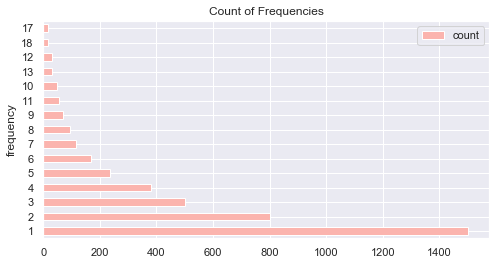

In [51]:
sns.set(rc={'figure.figsize':(8.0,4.0)})
frequency_grouped.head(15).plot.barh(x = 'frequency', y='count', colormap='Pastel1', title = 'Count of Frequencies')

The highest frequency of orders in 2011 is 188 orders. Most customers(1503 customers) bought in our store only once, around 800 customers bought twice, around 500 customers ordered 3 times in our store, etc. 

**MONETARY VALUE**

In [52]:
df['monetary_value'] = df.Quantity * df.UnitPrice

In [53]:
df.shape

(367022, 11)

In [54]:
monetary_value = df[['CustomerID','monetary_value']]

In [55]:
monetary_value = monetary_value.groupby('CustomerID',as_index=False).agg({'monetary_value':'sum'})\
.sort_values(by='monetary_value', ascending=False)

In [56]:
monetary_value.head()

,CustomerID,monetary_value
1653,14646,271614.14
4086,18102,231822.69
3636,17450,192361.95
2936,16446,168472.50
1840,14911,135973.23


In [57]:
monetary_value.shape

(4219, 2)

Let's create an RFM dataframe consisting of recency, frequency and monetary value that we've already found.

In [58]:
RFM = recency.merge(frequency, on='CustomerID')

In [59]:
RFM.shape

(4219, 4)

In [60]:
RFM = RFM.merge(monetary_value[['monetary_value','CustomerID']], on='CustomerID')

In [61]:
RFM.shape

(4219, 5)

In [62]:
RFM.head()

,CustomerID,last_purchase_date,recency,frequency,monetary_value
0,12346,2011-01-18 10:01:00,325,1,77183.60
1,12347,2011-12-07 15:52:00,1,6,3598.21
2,12348,2011-09-25 13:13:00,74,3,904.44
3,12349,2011-11-21 09:51:00,18,1,1757.55
4,12350,2011-02-02 16:01:00,309,1,334.40


In [63]:
RFM = RFM.drop(['last_purchase_date'], axis=1)

In [66]:
#Let's save this matrix for K-Means Clustering 
RFM.to_csv('C:/Users/Yoga/ML/RFM.csv')

Let's see the top 10 of Big Spenders:

In [67]:
RFM.sort_values(by='monetary_value', ascending=False).head(10)

,CustomerID,recency,frequency,monetary_value
1653,14646,1,71,271614.14
4086,18102,0,56,231822.69
3636,17450,7,44,192361.95
2936,16446,0,2,168472.50
1840,14911,0,188,135973.23
55,12415,23,21,124914.53
1304,14156,9,54,116887.88
3677,17511,2,28,84351.30
0,12346,325,1,77183.60
2636,16029,38,57,67738.32


Let's draw a scatter plot to get more insights. The darker and the bigger the size of the circle is, the more money they have spent: 

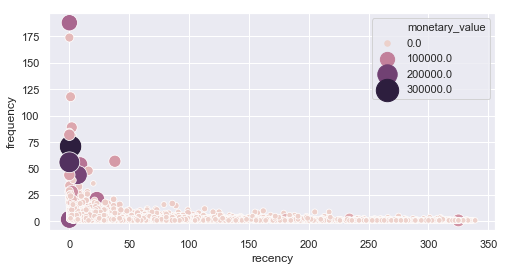

In [68]:
sns.set(rc={'figure.figsize':(8.0, 4.0)})
sns.scatterplot(x='recency', y='frequency', hue='monetary_value', size='monetary_value',\
                sizes=(30, 500), data=RFM)

Even without RFM-scores we can see that most of the top spenders have purchased in our store very recently - less than 25 days ago. As for frequency, most of the top spenders purchased between 20 and 75 times in 2011.<br/>
We can also see that some high spenders haven't purchased for more than 230 days ago. Would be nice to contact them with special offer. 

In [69]:
RFM_country = RFM.merge(df[['CustomerID','Country']], on='CustomerID',how='inner')

In [70]:
RFM_country = RFM_country.groupby('Country').agg({'monetary_value':'sum'})\
.sort_values(by='monetary_value', ascending=False)

In [71]:
#RFM_country['monetary_value'] = RFM_country['monetary_value'].round(2)

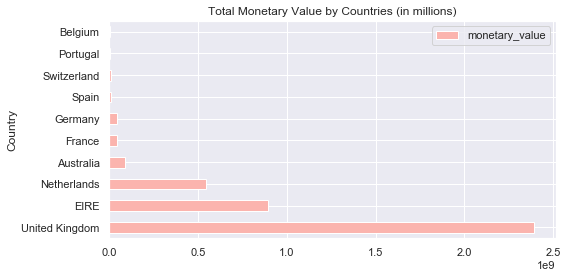

In [72]:
RFM_country.head(10).plot.barh(colormap='Pastel1', title= 'Total Monetary Value by Countries (in millions)')

Now let's attribute RFM scores to each customer. But before that let's check if our new dataframe contains correct values.

In [73]:
RFM.head()

,CustomerID,recency,frequency,monetary_value
0,12346,325,1,77183.60
1,12347,1,6,3598.21
2,12348,74,3,904.44
3,12349,18,1,1757.55
4,12350,309,1,334.40


In [74]:
customer=df[df.CustomerID==12346]

In [75]:
customer

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Year,monetary_value
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom,2011-01-18 10:01:00,2011,77183.6


In [76]:
now-customer.Date.max()

Timedelta('325 days 02:49:00')

In [77]:
customer.InvoiceNo.nunique()

1

In [78]:
customer.Quantity*customer.UnitPrice

61619    77183.6
dtype: float64

**RFM-MATRIX**

In [79]:
quartiles = RFM.drop('CustomerID',axis=1)
quartiles = quartiles.quantile(q=[0.25,0.5,0.75])
quartiles

,recency,frequency,monetary_value
0.25,16.0,1.0,302.64
0.50,46.0,2.0,657.80
0.75,127.0,4.0,1610.87


Let's create functions that will attribute RFM scores depending on the values. We need two functions, as low recency values should get 1 (best customer score) and low frequency and monetary values should get 4 (worst customer score).

In [80]:
quartiles.to_dict()

{'recency': {0.25: 16.0, 0.5: 46.0, 0.75: 127.0},
 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 4.0},
 'monetary_value': {0.25: 302.64, 0.5: 657.8, 0.75: 1610.8699999999994}}

In [81]:
def R_score(value,recency,quartiles):
    if value <= quartiles[recency][0.25]:
        return 1
    elif value <= quartiles[recency][0.50]:
        return 2
    elif value <= quartiles[recency][0.75]: 
        return 3
    else:
        return 4

def FM_score(value,FM,quartiles):
    if value <= quartiles[FM][0.25]:
        return 4
    elif value <= quartiles[FM][0.50]:
        return 3
    elif value <= quartiles[FM][0.75]: 
        return 2
    else:
        return 1

In [82]:
RFM['R_quartile'] = RFM['recency'].apply(R_score, args=('recency',quartiles))
RFM['F_quartile'] = RFM['frequency'].apply(FM_score, args=('frequency',quartiles))
RFM['M_quartile'] = RFM['monetary_value'].apply(FM_score, args=('monetary_value',quartiles))

In [83]:
RFM.head(10)

,CustomerID,recency,frequency,monetary_value,R_quartile,F_quartile,M_quartile
0,12346,325,1,77183.60,4,4,1
1,12347,1,6,3598.21,1,1,1
2,12348,74,3,904.44,3,2,2
3,12349,18,1,1757.55,2,4,1
4,12350,309,1,334.40,4,4,3
5,12352,35,8,2506.04,2,1,1
6,12353,203,1,89.00,4,4,4
7,12354,231,1,1079.40,4,4,2
8,12355,213,1,459.40,4,4,3
9,12356,22,3,2811.43,2,2,1


In [84]:
#Let's combine their scores in one column
RFM['RFM_score'] = RFM.R_quartile.map(str)\
+ RFM.F_quartile.map(str)+ \
+ RFM.M_quartile.map(str)

In [85]:
RFM.head()

,CustomerID,recency,frequency,monetary_value,R_quartile,F_quartile,M_quartile,RFM_score
0,12346,325,1,77183.60,4,4,1,441
1,12347,1,6,3598.21,1,1,1,111
2,12348,74,3,904.44,3,2,2,322
3,12349,18,1,1757.55,2,4,1,241
4,12350,309,1,334.40,4,4,3,443


In [86]:
RFM_matrix=RFM[['CustomerID','recency','frequency','monetary_value','RFM_score']]

In [87]:
RFM_matrix.head()

,CustomerID,recency,frequency,monetary_value,RFM_score
0,12346,325,1,77183.60,441
1,12347,1,6,3598.21,111
2,12348,74,3,904.44,322
3,12349,18,1,1757.55,241
4,12350,309,1,334.40,443


Let's also check what items are the most purchased in our store:

In [88]:
df.groupby('Description').agg({'CustomerID':'count'}).sort_values(by='CustomerID', ascending=False)\
.rename(columns= {'CustomerID':'count'}).head(10)

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,1809
REGENCY CAKESTAND 3 TIER,1574
JUMBO BAG RED RETROSPOT,1531
PARTY BUNTING,1366
ASSORTED COLOUR BIRD ORNAMENT,1302
LUNCH BAG RED RETROSPOT,1247
SET OF 3 CAKE TINS PANTRY DESIGN,1105
POSTAGE,1035
LUNCH BAG BLACK SKULL.,1032


# STAGE 3. INTERPRETING RESULTS

From the article <a href="https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales">How RFM Analysis Boosts Sales by Joao Correia </a>:<br/>
<br/>
**BEST CUSTOMERS (111):** Bought most recently and most often, and spend the most **_--> No price incentives, new products, and loyalty programs_**<br/>
<br/>
**LOYAL CUSTOMERS (X1X):** Buy most frequently **_--> Use R and M to further segment_**<br/>
<br/>
**BIG SPENDERS (XX1):** Spend the most **--> _Market your most expensive products_**<br/>
<br/>
**ALMOST LOST (311):** Haven’t purchased for some time, but purchased frequently and spend the most **_--> Aggressive price incentives_**<br/>
<br/>
**LOST CUSTOMERS (411):**	Haven’t purchased for some time, but purchased frequently and spend the most **_--> Aggressive price incentives_**<br/>
<br/>
**LOST CHEAP CUSTOMERS (444):** Last purchased long ago, purchased few, and spent little **_--> Don’t spend too much trying to re-acquire_**

In [89]:
best_customers = RFM[RFM.RFM_score=='111']
loyal_customers = RFM[RFM.F_quartile==1]
big_spenders = RFM[RFM.M_quartile==1]
almost_lost = RFM[RFM.RFM_score=='311']
lost_customers = RFM[RFM.RFM_score=='411']
lost_cheap_customers = RFM[RFM.RFM_score=='444']
columns = ['count']
segments = pd.DataFrame({'best_customers':best_customers.CustomerID.count()\
                         ,'loyal_customers':loyal_customers.CustomerID.count()\
                        ,'big_spenders':big_spenders.CustomerID.count()\
                         ,'almost_lost':almost_lost.CustomerID.count()\
                         ,'lost_customers':lost_customers.CustomerID.count()\
                         ,'lost_cheap_customers':lost_cheap_customers.CustomerID.count()},\
                        index=columns)
                         

In [90]:
segments = segments.transpose()
segments.head(10)

,count
best_customers,463
loyal_customers,1032
big_spenders,1055
almost_lost,100
lost_customers,9
lost_cheap_customers,424


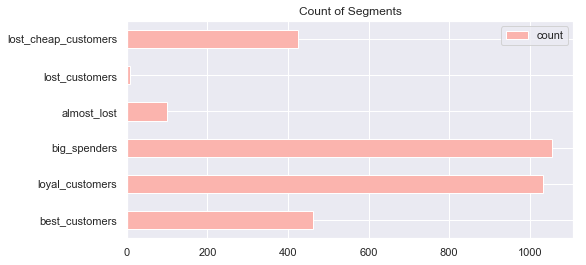

In [91]:
sns.set(rc={'figure.figsize':(8.0,4.0)})
segments.plot.barh(colormap='Pastel1', title= 'Count of Segments')

So, we can interpret this graph as follows:
1. Out of 4220 customers we've got over 400 people (Best Customers) who shop regularly, spend a lot and bought something recently.
2. We need to do something about two groups (Lost and Almost Lost Customers) that used to purchase frequenlty and spend a lot but haven't bought anything recently.
3. While treating Big Spenders and Loyal Customers, keep in mind that they overlap with each other and other segments, since they include all the customers with XX1 and X1X scores. If a marketing department decides to launch two different activities targeting these two groups, customers with X11 scores will be included in both promotional activities.If these activities are complementary and don't interfere with each other, then it's OK.<br/>

**However, the following segmentation is even more granular and doesn't have overlapping groups. Therefore, it might be more suitable for marketing purposes:**

In [92]:
count_scores=RFM.groupby('RFM_score', as_index= False).agg({'CustomerID':'count'})\
.sort_values(by='CustomerID', ascending=False)\
.rename(columns = {'CustomerID':'count'})

In [93]:
count_scores.head(10)

,RFM_score,count
0,111,463
61,444,424
60,443,229
16,211,212
45,344,200
20,222,152
30,244,150
44,343,148
35,322,132
5,122,112


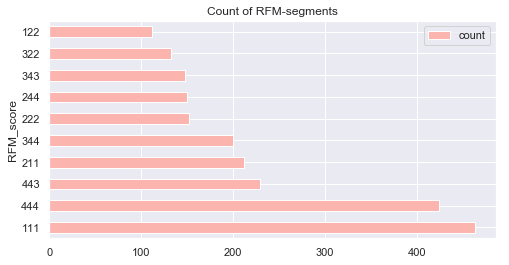

In [94]:
sns.set(rc={'figure.figsize':(8.0,4.0)})
count_scores.head(10).plot.barh(x='RFM_score', y='count', colormap='Pastel1', title='Count of RFM-segments')

Best Customers and Lost Cheap Customers are two biggest groups that have around 400 people each.

**Let's have a closer look at the groups of Big Spenders and Loyal Customers:**

In [95]:
#Let's see the percentage of the revenue that Big Spenders bring:
big_spenders['monetary_value'].sum()/df['monetary_value'].sum()*100

78.78859191262958

Let's find the most popular products that have been purchased by Big Spenders:

In [96]:
big_spenders_items = big_spenders.merge(df[['CustomerID','Description']], on='CustomerID', how ='inner')

In [97]:
big_spenders.shape

(1055, 8)

In [98]:
#Since every customer was added all the items they bought, the number of rows much bigger
big_spenders_items.shape

(235209, 9)

In [99]:
big_spenders_items = big_spenders_items.groupby('Description').agg({'CustomerID':'count'})\
.sort_values(by='CustomerID', ascending=False)\
.rename(columns = {'CustomerID':'count'})
big_spenders_items.head(10)

,count
Description,
JUMBO BAG RED RETROSPOT,1193
WHITE HANGING HEART T-LIGHT HOLDER,1075
REGENCY CAKESTAND 3 TIER,1016
LUNCH BAG RED RETROSPOT,980
PARTY BUNTING,910
ASSORTED COLOUR BIRD ORNAMENT,767
LUNCH BAG BLACK SKULL.,749
SET OF 3 CAKE TINS PANTRY DESIGN,731
SPOTTY BUNTING,694


Where are the Big Spenders from?

In [100]:
big_spenders_countries = big_spenders.merge(df[['CustomerID','Country']], on='CustomerID', how ='inner')

In [101]:
big_spenders_countries.shape

(235209, 9)

In [102]:
big_spenders_countries = big_spenders_countries.drop_duplicates(subset=['CustomerID'])

In [103]:
big_spenders_countries.shape

(1055, 9)

In [104]:
big_spenders_countries = big_spenders_countries.groupby('Country').agg({'CustomerID':'count'})\
.sort_values(by='CustomerID', ascending=False)\
.rename(columns = {'CustomerID':'count'})
big_spenders_countries.head(10)

,count
Country,
United Kingdom,903
Germany,38
France,30
Belgium,10
Switzerland,10
Spain,7
Portugal,7
Norway,7
Channel Islands,5


What are the most popular RFM-scores among the Big Spenders?

In [105]:
big_spenders_grouped = big_spenders.groupby('RFM_score').agg({'CustomerID':'count'})\
.sort_values(by='CustomerID', ascending=False)\
.rename(columns={'CustomerID':'count'})
big_spenders_grouped

,count
RFM_score,
111,463
211,212
311,100
321,61
121,58
221,58
421,17
331,15
231,14


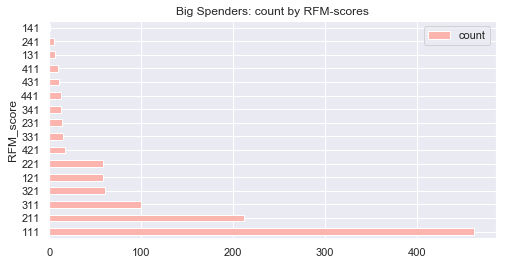

In [106]:
sns.set(rc={'figure.figsize':(8.0,4.0)})
big_spenders_grouped.plot.barh(colormap='Pastel1', title = 'Big Spenders: count by RFM-scores')

This provides us with some interesting insights about those who brought 78% of revenue in 2011 (Big Spenders):
1. Not all of them are loyal customers. However, it would make sense to separate wholesalers from regular customers, as they need different types of promotions. They might buy rarely but in large quantities.
2. Some of them haven't bought from the store for quite a while and need to be taken care of as soon as possible.
3. We identified the most and the least purchased items for Big Spenders.
4. Most of our Big Spenders are from the UK, Germany and France.

The most popular items bought by Loyal Customers:

In [107]:
loyal_customers_items = loyal_customers.merge(df[['CustomerID','Description']], on='CustomerID', how ='inner')

In [108]:
loyal_customers_items = loyal_customers_items.groupby('Description')\
.agg({'CustomerID':'count'}).sort_values(by='CustomerID', ascending=False)\
.rename(columns = {'CustomerID':'count'})
loyal_customers_items.head(10)

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,1125
JUMBO BAG RED RETROSPOT,1101
REGENCY CAKESTAND 3 TIER,978
LUNCH BAG RED RETROSPOT,946
PARTY BUNTING,877
ASSORTED COLOUR BIRD ORNAMENT,773
LUNCH BAG BLACK SKULL.,766
SET OF 3 CAKE TINS PANTRY DESIGN,702
LUNCH BAG PINK POLKADOT,668


Where are the Loyal Customers from?

In [109]:
loyal_customers_countries = loyal_customers.merge(df[['CustomerID','Country']], on='CustomerID', how ='inner')

In [110]:
loyal_customers.shape

(1032, 8)

In [111]:
loyal_customers_countries.shape

(230059, 9)

In [112]:
loyal_customers_countries = loyal_customers_countries.drop_duplicates(subset=['CustomerID'])

In [113]:
loyal_customers_countries.shape

(1032, 9)

In [114]:
loyal_customers_countries = loyal_customers_countries.groupby('Country')\
.agg({'CustomerID':'count'}).sort_values(by='CustomerID', ascending=False)\
.rename(columns = {'CustomerID':'count'})
loyal_customers_countries.head(10)

,count
Country,
United Kingdom,928
Germany,29
France,27
Belgium,7
Norway,5
Spain,4
Australia,4
Finland,3
Italy,3


The most popular RFM-scores among the Loyal Customers:

In [115]:
loyal_customers_grouped = loyal_customers.groupby('RFM_score').agg({'CustomerID':'count'})\
.sort_values(by='CustomerID', ascending=False)\
.rename(columns={'CustomerID':'count'})
loyal_customers_grouped

,count
RFM_score,
111,463
211,212
112,103
311,100
212,81
312,34
411,9
412,8
113,7


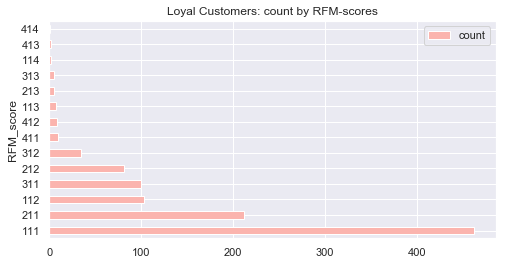

In [116]:
sns.set(rc={'figure.figsize':(8.0,4.0)})
loyal_customers_grouped.plot.barh(colormap='Pastel1', title='Loyal Customers: count by RFM-scores')

This gives us some ideas about our Loyal Customers:
1. We can see that not all of our loyal customers are big spenders. Nevertheless, they are very important for the business, as they spread the word about the company. 
2. We can see that some of our loyal customers haven't purchased from us for a while, so we need to take actions as not to lose them.
3. We identified the most and the least purchased items for Big Spenders.
4. Our Loyal Customers are mostly from the UK, Germany and France

**Let's see what items are the most purchased by Lost Cheap Customers:**

In [117]:
lost_cheap_customers_items = lost_cheap_customers.merge(df[['CustomerID','Description']], on='CustomerID', how ='inner')

In [118]:
lost_cheap_customers_items = lost_cheap_customers_items.groupby('Description')\
.agg({'CustomerID':'count'}).sort_values(by='CustomerID', ascending=False)\
.rename(columns = {'CustomerID':'count'})
lost_cheap_customers_items.head(10)

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,51
PARTY BUNTING,41
REX CASH+CARRY JUMBO SHOPPER,35
REGENCY CAKESTAND 3 TIER,34
NATURAL SLATE HEART CHALKBOARD,30
HEART OF WICKER SMALL,25
RETROSPOT TEA SET CERAMIC 11 PC,24
BAKING SET 9 PIECE RETROSPOT,24
VICTORIAN GLASS HANGING T-LIGHT,23


Let's find the countries where the Lost Cheap Customers are from:

In [119]:
lost_cheap_customers_countries = lost_cheap_customers.merge(df[['CustomerID','Country']], on='CustomerID', how ='inner')

In [120]:
lost_cheap_customers.shape

(424, 8)

In [121]:
lost_cheap_customers_countries.shape

(5696, 9)

In [122]:
lost_cheap_customers_countries = lost_cheap_customers_countries.drop_duplicates(subset=['CustomerID'])

In [123]:
lost_cheap_customers_countries.shape

(424, 9)

In [124]:
lost_cheap_customers_countries = lost_cheap_customers_countries.groupby('Country')\
.agg({'CustomerID':'count'}).sort_values(by='CustomerID', ascending=False)\
.rename(columns = {'CustomerID':'count'})
lost_cheap_customers_countries.head(10)

,count
Country,
United Kingdom,400
France,8
Belgium,3
Germany,3
Japan,2
Australia,1
Austria,1
Bahrain,1
Canada,1


**Let's add FM-dimensions to the scatter plot we've seen before.**<br/> 
The bigger the size of a circle is, the more money they have spent.<br/>
The higher the F-score is, the lower the frequency of purchases.<br/>
Monetary value quartiles are coded as follows:<br/>
1. M-score 1: pink, monetary value >= 1611 
2. M-score 2: light blue,  658 =< monetary value =< 1611 
3. M-score 3: yellow, 303  =< monetary value =< 658
4. M-score 4: black, monetary value <= 303

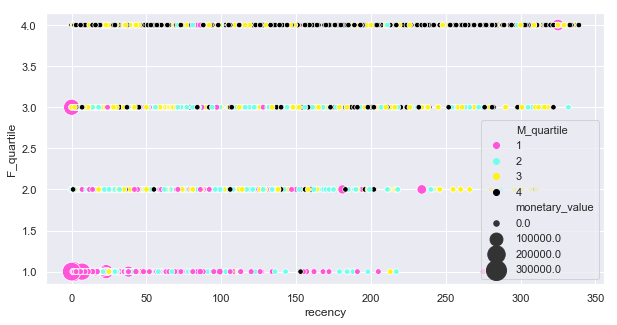

In [125]:
sns.set(rc={'figure.figsize':(10.0, 5.0)})
color_dict = dict({1:'#ff55da',
                  2:'#70ffec',
                  3: '#fff30e',
                  4: '#000000'})
sns.scatterplot(x='recency', y='F_quartile', hue = 'M_quartile',\
                size='monetary_value', sizes=(30, 400), 
                palette=color_dict, data=RFM)

This scatter plot gives us more insights:<br/>
1. Customers with M-score 1 (pink circles) have different sizes of circles. Those with bigger sizes are likely to be wholesalers and they have spent far more than the regular customers. Once again, it would be better to separate them from regular customers for better analysis.
2. We can see that some of our loyal customers haven't spent much (black and yellow circles on F_quartile 1 and 2). We can analyse further what they buy, etc to understand if we can make them spend more. Anyway, it's good to have them despite their low monetray values, as they create positive word-of-mouth.
3. We can see a customer that more than 300 days ago spent nearly 100000. Probably, a lost customer(upper-right corner) but worth trying to get them back.
4. Most of our loyal customers (F_quartile 1) have purchased from us less than 200 days, in contrast to our less frequent customers.
5. We have some customers that bring good money but purchase rarerly (light blue circles on F_quartile 3). We can incentivise them to purchase more often.

**Finally, let's see the dynamics of revenue throughout the year.**

In [126]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Year,monetary_value
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,1/4/2011 10:00,1.95,13313,United Kingdom,2011-01-04 10:00:00,2011,19.5
42482,539993,21499,BLUE POLKADOT WRAP,25,1/4/2011 10:00,0.42,13313,United Kingdom,2011-01-04 10:00:00,2011,10.5
42483,539993,21498,RED RETROSPOT WRAP,25,1/4/2011 10:00,0.42,13313,United Kingdom,2011-01-04 10:00:00,2011,10.5
42484,539993,22379,RECYCLING BAG RETROSPOT,5,1/4/2011 10:00,2.10,13313,United Kingdom,2011-01-04 10:00:00,2011,10.5
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,1/4/2011 10:00,1.25,13313,United Kingdom,2011-01-04 10:00:00,2011,12.5


In [127]:
df.dtypes

InvoiceNo                 object
StockCode                 object
Description               object
Quantity                   int64
InvoiceDate               object
UnitPrice                float64
CustomerID                 int32
Country                   object
Date              datetime64[ns]
Year                       int64
monetary_value           float64
dtype: object

In [128]:
df.index = df.Date

Let's see how many unique customers purchased in our store every month and week.

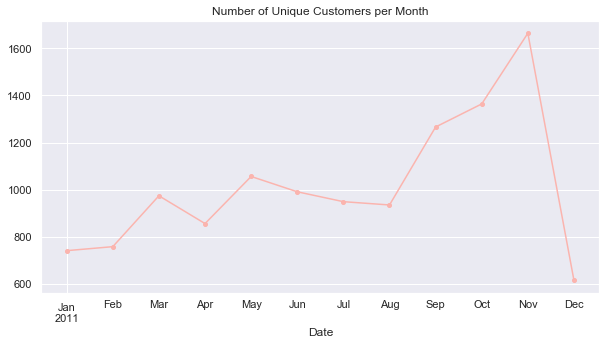

In [129]:
df.resample('M').CustomerID.nunique().plot(colormap='Pastel1',markersize=4, marker='o',\
                                           title='Number of Unique Customers per Month')

From this analysis we can clearly see the dynamics of purchases in 2011. The gradually rising unique number of customers soared in November and plummeted in December. 

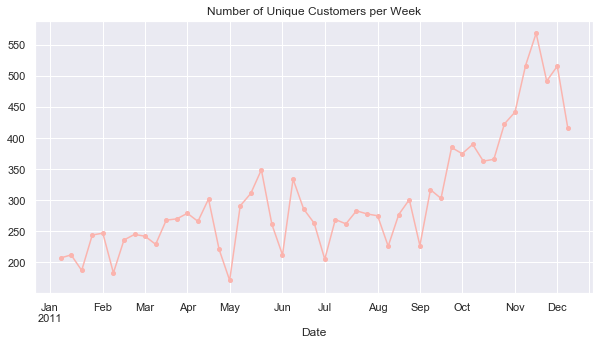

In [130]:
df.resample('W').CustomerID.nunique().plot(colormap='Pastel1',markersize=4, marker='o',\
                                           title='Number of Unique Customers per Week')

Numbers of unique customers by weeks shows us that the unique number of customers fluctuated during the same months, e.g. in summer.

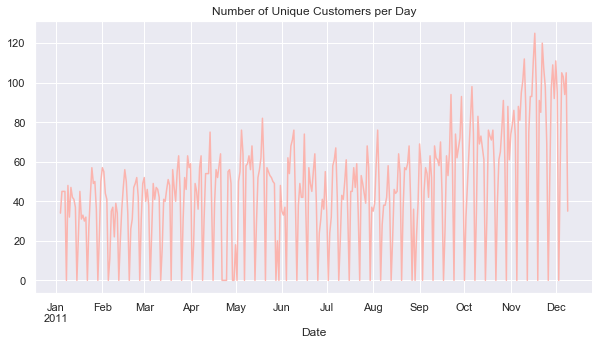

In [131]:
df.resample('D').CustomerID.nunique().plot(colormap='Pastel1', title='Number of Unique Customers per Day')

From the graph above we can see that the store didn't work at weekends. It is alss important to know what months and weeks were the most and the least profitable.

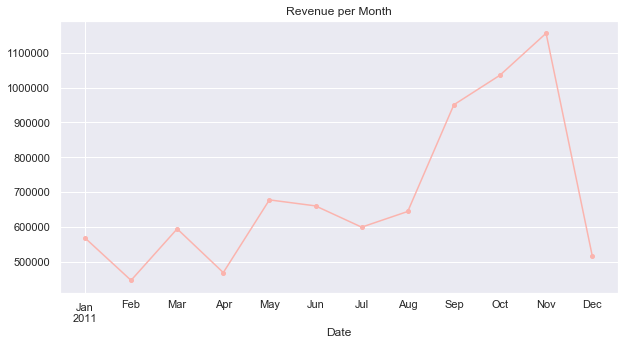

In [132]:
df.resample('M').monetary_value.sum().plot(colormap='Pastel1',markersize=4, marker='o',\
                                          title='Revenue per Month')

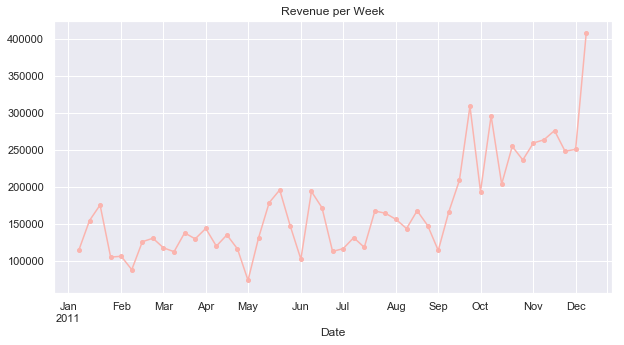

In [133]:
df.resample('W').monetary_value.sum().plot(colormap='Pastel1',markersize=4, marker='o',\
                                          title='Revenue per Week')

From the two graphs above we can see that the revenue seemingly increased with the number of customers. Let's combine these two graphs to see whether the bigger number of unique customers means the bigger revenue.

In [134]:
resampled = df.resample('W').monetary_value.sum()

In [135]:
resampled_2 = df.resample('W').CustomerID.nunique()

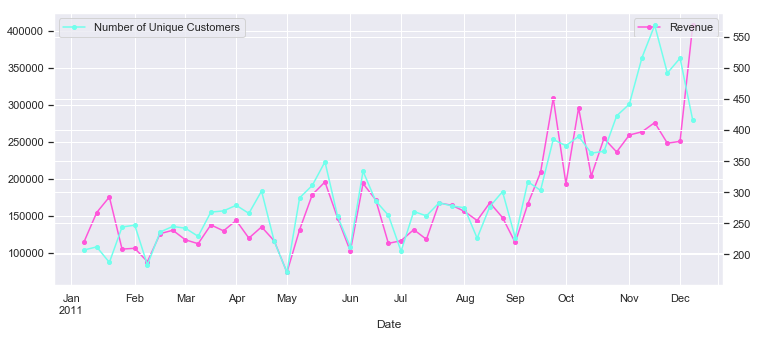

In [136]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of Unique Customers and Revenue')

ax1 = resampled.plot(color='#ff55da', grid=True, label='Revenue',markersize=4, marker='o')
ax2 = resampled_2.plot(color='#70ffec', grid=True, secondary_y=True,\
                       label='Number of Unique Customers',markersize=4, marker='o',)

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

From the graph above we can see that in November the number of unique customers increased drammatically but the revenue slightly decreased, which means that in November we had many customers that didn't buy much. However, in December the number of customers decreased while the revenue increased drammatically. Probably, the wholesalers bought something for Christmas. 

# CONCLUSION

In this analysis I identified different customer groups upon which the actions can be taken:
1. Lost and Almost Lost customers.
2. Loyal Customers that don't spend a lot in our stores.
3. Big Spenders that purchase rarely.
4. Most of the customers are from the UK. Top customers among Big Spenders and Loyal Customers are from the UK, Germany and France.
For future analysis it would be good to separate wholesalers from regular customers, as they need different promotional incentives. In addition, separate analysis of these two groups can yeild in additional insights. 
5. The number of customers fluctuated throughout the year with November being the most profitable month.